# 直方图

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
src = cv2.imread('../datas/f4.jpg')
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
rgb_f = rgb.astype(np.float32)

src2 = cv2.imread('../datas/f2.jpg')
rgb2 = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
rgb_f2 = rgb.astype(np.float32)

## 1.灰度图像直方图

In [3]:
hist = cv2.calcHist([gray],  
    [0], #使用的通道  
    None, #没有使用mask  
    [256], #HistSize  
    [0.0,255.0]) #直方图柱的范围  

Text(0.5,1,'Histgraom of Gray Image')

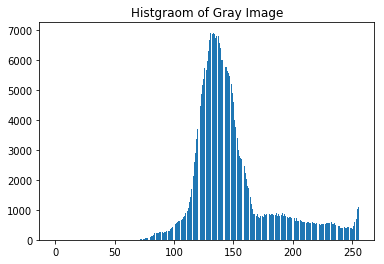

In [4]:
plt.bar(np.arange(0,256),hist.astype(np.int32).reshape((256,)))
plt.title('Histgraom of Gray Image')

In [5]:
def calcAndDrawHist(image, color):    
    hist= cv2.calcHist([image], [0], None, [256], [0.0,255.0])    
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(hist)    
    histImg = np.zeros([256,256,3], np.uint8)    
    hpt = int(0.9* 256);    
        
    for h in range(256):    
        intensity = int(hist[h]*hpt/maxVal)    
        cv2.line(histImg,(h,256), (h,256-intensity), color)    
            
    return histImg;   

In [6]:
histimg = calcAndDrawHist(gray,(255,0,0))

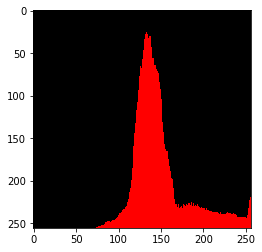

In [7]:
plt.imshow(histimg)

## 2.彩色图像直方图

In [8]:
histImgR = calcAndDrawHist(rgb[:,:,0], [255, 0, 0])    
histImgG = calcAndDrawHist(rgb[:,:,1], [0, 255, 0])    
histImgB = calcAndDrawHist(rgb[:,:,2], [0, 0, 255]) 

Text(0.5,1,'Channel B')

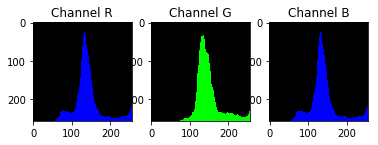

In [9]:
plt.subplot(131)
plt.imshow(histImgB)
plt.title('Channel R')
plt.subplot(132)
plt.imshow(histImgG)
plt.title('Channel G')
plt.subplot(133)
plt.imshow(histImgB)
plt.title('Channel B')

## 3.灰度图像直方图均衡化

Text(0.5,1,'Histogram Equation')

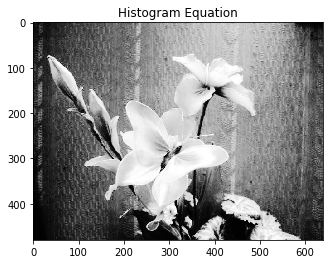

In [10]:
dst_gray_eq = cv2.equalizeHist(gray)
plt.imshow(dst_gray_eq,'gray')
plt.title('Histogram Equation')

## 4.彩色图像均衡化

Text(0.5,1,'Histogram Equation')

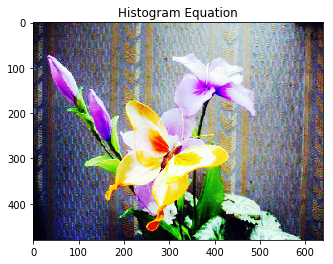

In [11]:
channels = cv2.split(rgb)
histeq_r =  cv2.equalizeHist(channels[0])
histeq_g =  cv2.equalizeHist(channels[1])
histeq_b =  cv2.equalizeHist(channels[2])
dst_rgb_eq = cv2.merge([histeq_r,histeq_g,histeq_b])
plt.imshow(dst_rgb_eq)
plt.title('Histogram Equation')

## 5.直方图变换-查找

In [12]:
#1.计算直方图
hist = cv2.calcHist([gray],  
    [0], #使用的通道  
    None, #没有使用mask  
    [256], #HistSize  
    [0.0,255.0]).reshape((256,)) #直方图柱的范围  

#2.根据预设统计灰度级变换
segThreshold = 50

# 由低到高查找
idx = np.arange(0,256)
low = 0
for i in idx:
    low = i
    if hist[i] > segThreshold:
        break
high = 0
idx_r = idx[::-1]
for i in idx_r:
    high = i
    if hist[i] > segThreshold:
        break

#3.建立查找表
lookup_table = np.zeros((256,),dtype=np.float32)
for i in range(256):
    if i < low:
        lookup_table[i] = 0
    elif i > high:
        lookup_table[i] = 255
    else:
        lookup_table[i] = 255.0 * (i - low) / (high - low + 0.5)
lookup_table = lookup_table.astype(np.uint8)

#4.重新映射
dst_lut = cv2.LUT(gray,lookup_table)

In [13]:
hist_lut = calcAndDrawHist(dst_lut, [0, 0, 255])
hist_gray = calcAndDrawHist(gray, [0, 0, 255])

In [14]:
print(dst_lut.shape)

(480, 640)


Text(0.5,1,'Histgrom of LUT')

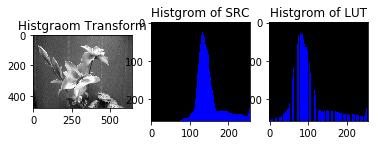

In [15]:
plt.subplot(131)
plt.imshow(dst_lut,'gray')
plt.title('Histgraom Transform')
plt.subplot(132)
plt.imshow(hist_gray)
plt.title('Histgrom of SRC')
plt.subplot(133)
plt.imshow(hist_lut)
plt.title('Histgrom of LUT')

## 6.直方图变换-累计

In [16]:
#1.计算直方图
hist = cv2.calcHist([gray],  
    [0], #使用的通道  
    None, #没有使用mask  
    [256], #HistSize  
    [0.0,255.0]).reshape((256,)) #直方图柱的范围  

#2.累计
table = np.zeros((256,),dtype=np.float32)
temp = np.arange(0,256).astype(np.float32)
npixels = gray.shape[0] * gray.shape[1]
temp = hist / npixels * 255.0
for i in range(256):
    if i != 0:
        table[i] = table[i - 1] + temp[i]
    else:
        table[i] = temp[i]
table = table.astype(np.uint8)
dst_acc = cv2.LUT(gray,table)
hist_lut_acc = calcAndDrawHist(dst_acc, [0, 0, 255])

Text(0.5,1,'Histgrom of ACC')

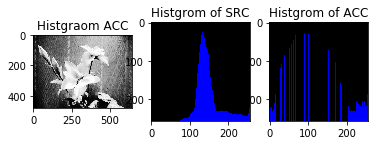

In [17]:
plt.subplot(131)
plt.imshow(dst_acc,'gray')
plt.title('Histgraom ACC')
plt.subplot(132)
plt.imshow(hist_gray)
plt.title('Histgrom of SRC')
plt.subplot(133)
plt.imshow(hist_lut_acc)
plt.title('Histgrom of ACC')

## 7.直方图匹配

In [24]:
rows,cols = gray.shape
# 初始化累计分布参数
srcCdfArr = np.zeros((256,),dtype=np.float32)
dstCdfArr = np.zeros_like(srcCdfArr)
srcAddTemp = np.zeros((256,),dtype=np.int32)
dstAddTemp = np.zeros_like(srcAddTemp)
histMatchMap = np.zeros_like(dstAddTemp)

sumSrcTemp = 0.0
sumDstTemp = 0.0
nSrcPix = rows * cols
matchFlag = 0
tmpsrc = gray.reshape((rows*cols,)).tolist()
tmpdst = gray2.reshape((rows*cols,)).tolist()
# 求解源图像与目标图像的累计直方图
for i in range(256):
    srcAddTemp[i] = tmpsrc.count(i)
    dstAddTemp[i] = tmpdst.count(i)
    
# 求解源图像与目标图像的累计概率分布
for i in range(256):
    sumSrcTemp += srcAddTemp[i]
    srcCdfArr[i] = sumSrcTemp / nSrcPix
    sumDstTemp += dstAddTemp[i]
    dstCdfArr[i] = sumDstTemp / nSrcPix

# 直方图匹配实现
for i in range(256):
    minMatchPara = 20
    for j in range(256):
        # 判断当前直方图累计差异
        diff = np.abs(srcCdfArr[i] - dstCdfArr[i])
        if minMatchPara > diff:
            minMatchPara = diff
            matchFlag = j
    histMatchMap[i] = matchFlag
histMatchMap = histMatchMap.astype(np.uint8)
histMatchImg = cv2.LUT(gray,histMatchMap)

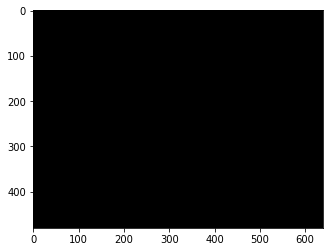

In [22]:
plt.imshow(histMatchImg,'gray')

## 8.直方图对比

cv2.HISTCMP_CORREL     Correlation

cv2.HISTCMP_CHISQR     Chi-Square

cv2.HISTCMP_CHISQR_ALT     Alternative Chi-Square

cv2.HISTCMP_INTERSECT     Intersection

cv2.HISTCMP_BHATTACHARYYA     Bhattacharyya distance

cv2.HISTCMP_HELLINGER     Synonym for CV_COMP_BHATTACHARYYA

cv2.HISTCMP_KL_DIV     Kullback-Leibler divergence

In [29]:
histr = cv2.calcHist([gray],[0],None,[256],[0,256])
histg = cv2.calcHist([gray2],[0],None,[256],[0,256])
cv2.normalize(histr, histr, 0, 1, cv2.NORM_MINMAX)
cv2.normalize(histg, histg, 0, 1, cv2.NORM_MINMAX)
result = cv2.compareHist(histr,histg,cv2.HISTCMP_CORREL)
print(result)

1.0


## 9.直方图反射投影

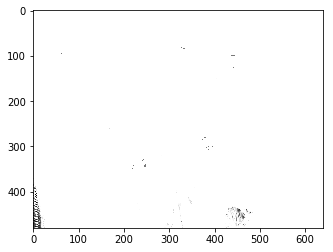

In [32]:
src2 = cv2.imread('../datas/f4_1.jpg')
rgb2 = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
rgb_f2 = rgb.astype(np.float32)
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
bp = cv2.calcBackProject([gray2], [0], hist, [0, 256], 1)
plt.imshow(bp,'gray')

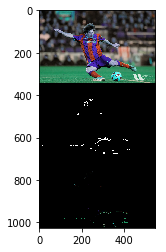

In [35]:
roi = cv2.imread('../datas/grass.jpg')
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)

target = cv2.imread('../datas/messi5.jpg')
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

# calculating object histogram
roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# normalize histogram and apply backprojection
cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

# Now convolute with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(dst,-1,disc,dst)

# threshold and binary AND
ret,thresh = cv2.threshold(dst,50,255,0)
thresh = cv2.merge((thresh,thresh,thresh))
res = cv2.bitwise_and(target,thresh)

res = np.vstack((target,thresh,res))
plt.imshow(res)
# cv2.imwrite('res.jpg',res)

# res = cv2.imread('res.jpg')
# cv2.imshow('image', res)
# cv2.waitKey(0)
# cv2.destroyAllWindows